# Calculation of the deflection angle in a two-body system
---

The problem deals with the calculation of the deflection angle **θ** of two colliding structureless bodies under the effect of the potential **V(r)** (with **r** being the distance between the two bodies) without integrating the related Hamilton equations.

Such solution is obtained by transforming the 12 dimensional two body problem into that of a single particle of reduced mass **µ** using the center of mass frame and imposing the conservation of Energy **E** and the total angular momentum (see *A. Laganà and G.A. Parker, Basic theory and computing for understanding chemical reactions, Springer* (in the press)).

The expression for θ is:

$$\theta=2b\int_{a}^{\infty} \frac{dr}{r^2 \sqrt{1-b^2 / r^2 - V(r) / E}} $$

in which **b** is the impact parameter.

To follow, we compare first the analytical solution:

$$ \theta= 2 arcsin(\frac{1}{\sqrt{1+4b^2E^2}}) $$

for the potential $V(r) = \frac{1}{r}$ with the numerical quadrature of the integral given above.

Next we can see the corresponding  Python code whose dependence on the impact parameter:

Calculus may take some time...
b = 0	theta = 180.0	analytic = 180.0
b = 1	theta = 157.71171695	analytic = 157.380135052
b = 2	theta = 137.088104868	analytic = 136.397181027
b = 3	theta = 119.092114716	analytic = 118.072486936
b = 4	theta = 104.062716039	analytic = 102.680383492
b = 5	theta = 91.790209612	analytic = 90.0
b = 6	theta = 81.7489129414	analytic = 79.6111421845
b = 7	theta = 73.5160244904	analytic = 71.0753555839
b = 8	theta = 66.6812778658	analytic = 64.0107664162
b = 9	theta = 61.0917587125	analytic = 58.1092081982
b = 10	theta = 56.6305378746	analytic = 53.1301023542
b = 11	theta = 52.7540856605	analytic = 48.8879095608
b = 12	theta = 49.3995915407	analytic = 45.2397298961
b = 13	theta = 46.5965056491	analytic = 42.0750220508
b = 14	theta = 44.1895732922	analytic = 39.3076481161
b = 15	theta = 42.0375276228	analytic = 36.8698976458


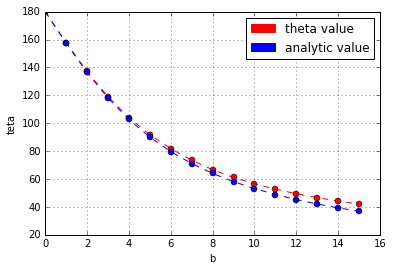

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from math import sqrt, degrees, asin

MAX_DIVISIONS = 21
MAX_ITERATIONS = 21
PRECISION_DELTA = 0.00000002
DELTA = 16.0


def analytic_evaluation(var_b, var_e):
    """Analytic function of theta integral."""
    return 2.0 * asin(1 / (sqrt(1 + 4 * var_b ** 2 * var_e ** 2)))


def integral_func(var_r, var_b, var_e):
    """Integral to calculate."""
    potential = lambda var_r: 1.0 / var_r
    try:
        return 1.0 / (
            var_r**2 * sqrt(1 - (var_b**2 / var_r**2) - (
                potential(var_r) / var_e)))
    except ValueError:
        return 0.0
    except ZeroDivisionError:
        return 0.0


def finite_integral(var_up, var_to, var_b, var_e):
    """Finite Riemann integral."""
    prev_sum = 0.0

    for i in range(MAX_DIVISIONS):

        step = (var_to-var_up) / 2**i
        partial_sum = 0.0
        cur_step = var_up + step

        while cur_step <= var_to:

            f_x = step * integral_func(cur_step - (step/2.0), var_b, var_e)
            partial_sum += f_x
            cur_step += step

        if prev_sum != 0.0 and abs(prev_sum - partial_sum) < PRECISION_DELTA:
            break

        prev_sum = partial_sum

    return partial_sum


def integral_to_infinite(var_up, var_b, var_e):
    """Riemann integral open at right plus final multiplication."""
    prev_res = 0.0

    for i in range(MAX_ITERATIONS):

        var_to = var_up + DELTA
        partial_res = finite_integral(var_up, var_to, var_b, var_e)

        if prev_res != 0.0 and partial_res != 0.0\
                and partial_res < PRECISION_DELTA:
            break

        prev_res += partial_res
        var_up = var_to

    return (2.0 * var_b) * prev_res


var_a = 0.0
var_e = 0.1

points_x = []
points_y = []
points_y_a = []

print("Calculus may take some time...")

for var_b in range(0, 16):
    points_x.append(var_b)

    final_theta = 180.0 - degrees(abs(integral_to_infinite(var_a, var_b, var_e)))
    analytic = degrees(analytic_evaluation(var_b, var_e))

    print("b = {}\ttheta = {}\tanalytic = {}".format(var_b, final_theta, analytic))

    points_y.append(final_theta)
    points_y_a.append(analytic)

plt.ylabel('teta')
plt.xlabel('b')
plt.plot(points_x, points_y, 'r--')
plt.plot(points_x, points_y, 'ro')
plt.plot(points_x, points_y_a, 'b--')
plt.plot(points_x, points_y_a, 'bo')
red_line = mpatches.Patch(color='red', label='theta value')
blue_line = mpatches.Patch(color='blue', label='analytic value')
plt.legend(handles=[red_line, blue_line])
plt.grid(True)
plt.figure()

The implementation of the program gave us values similar to the analytic function. 

The major problems arouse from:

* finding conditions to terminate the computation
* finding the appropriate error tolerance
* deciding how and how many the interactions have to be

For the generic potential V(r) not having an analytical solution we did not consider to use the above described Python script because its performance is low due to the limitation of Python VM and of its interpreted nature.

We considered instead to use a combination of the **C language** and **Python**. This is also the first step to implement the code using C MPI API for parallel runs.

First of all the C code:

```c
#ifdef _WIN32
    #define _USE_MATH_DEFINES
#endif

#include <stdio.h>
#include <math.h>

const size_t MAX_DIVISIONS = 21;
const size_t MAX_ITERATIONS = 21;
const double PRECISION_DELTA = 0.00000001;
const double DELTA = 16.0;

double potential(double r)
{
    return 1.0/r;
}

double function(double r, double b, double E)
{  
    return 1.0 / (pow(r, 2) * sqrt(1 - (pow(b, 2) / pow(r, 2)) - (potential(r) / E)));
}

double finite_integral(double up, double to, double b, double E)
{
    double cur_step,
           step,
           prev_sum,
           partial_sum,
           f_x;
    size_t i;

    prev_sum = 0.0;

    for(i = 0; i != MAX_DIVISIONS; ++i)
    {
        step = (to-up)/pow(2, i);
        partial_sum = 0.0;

        for(cur_step = up + step; cur_step <= to; cur_step += step) {
            f_x = step * function(cur_step - (step/2.0), b, E);
            
            // when f_x is nan
            // if f_x is nan, f_x != f_x will be true
            if(f_x == f_x) {  
                partial_sum = partial_sum + f_x;
            }
        }

        if(prev_sum != 0.0 && fabs(prev_sum - partial_sum) < PRECISION_DELTA) break;
        prev_sum = partial_sum;
    }
    
    return partial_sum;
}

double integral_to_infinite(double a, double b, double E)
{
    double to,
           prev_res,
           partial_res;
    size_t i;

    prev_res = 0.0;
    
    for(i = 1; i != pow(2, MAX_ITERATIONS); ++i)
    {
        to = a + DELTA;
        partial_res = finite_integral(a, to, b, E);

        if(prev_res != 0.0 && partial_res != 0.0 && partial_res < PRECISION_DELTA)
        {
            prev_res += partial_res;
            break;
        }

        prev_res += partial_res;
        a = to;
    }

    return (2.0 * b) * prev_res;
}

double to_degrees(double radians) {
    return 180.0 - radians * (180.0 / M_PI);
}
```

The approach is the same of the Python code given above. Now we can see how to implement this code with Python:

```python
from cffi import FFI
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from ctypes import c_double
from math import asin, sqrt, degrees


def analytic_evaluation(var_b, var_e):
    """Analytic function of theta integral."""
    return 2.0 * asin(1 / (sqrt(1 + 4 * float(var_b) ** 2 * float(var_e) ** 2)))


def range_f(start, end, step):
    """Create a list of double values."""
    end = c_double(end)
    ffi = FFI()
    start = c_double(start)
    while start.value <= end.value:
        yield ffi.cast("double", start.value)
        start.value = start.value + c_double(step).value


def main():
    """Program main."""
    ffi = FFI()
    ffi.cdef("""
double integral_to_infinite(double a, double b, double E);
double to_degrees(double radians);

""")
    lib = ffi.verify("""
#include "tetaQuad.h"
""", include_dirs=["."], extra_compile_args=["-O3"])

    var_e = ffi.cast("double", 0.1)
    var_a = ffi.cast("double", 0.0)

    points_x = []
    points_y = []
    points_y_a = []

    print("Calculus may take some time...")

    for var_b in range_f(0.0, 100, 0.5):
        points_x.append(var_b)
        rad = lib.integral_to_infinite(var_a, var_b, var_e)
        theta = lib.to_degrees(abs(rad))
        analytic = degrees(analytic_evaluation(var_b, var_e))

        print("b = {}\ttheta = {}\tanalytic = {}".format(
            float(var_b), theta, analytic))

        points_y.append(theta)
        points_y_a.append(analytic)

    plt.ylabel('teta')
    plt.xlabel('b')
    plt.plot(points_x, points_y, 'ro')
    plt.plot(points_x, points_y_a, 'b--')
    red_line = mpatches.Patch(color='red', label='theta value')
    blue_line = mpatches.Patch(color='blue', label='analytic value')
    plt.legend(handles=[red_line, blue_line])
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    main()

```

<img src="./img/thetaEvaluation_cffi_repulsive.png" />

As we can see now the performance that we reached with the **C implementation** gave us a better chart in less than a minute. Obviously this is a start point to improve the code with a parallel implementation, searching for the tasks that can run concurrently.

Here we consider the **Lennard-Jones potential** (attractive-repulsive):

<img src="./img/thetaEvaluation_cffi_lennardjones.png" />

The chart values are almost as we expected, and still there is room for improvement. For example, we can improve precision by refining the quadrature method especially when using more complex kinds of potential functions.

The unit of measure used are submultiples of the *m* and *s*, respectively *nanometer* ($10^{-9}m$) and *millisecond* ($10^{-3}s$). For the potential we can misure it in *millielectron* ($10^{-3}eV, meV$).